# **Sentiment Analysis with Hugging Face**

In [ ]:
'''!pip install "accelerate>=0.20.1" -U
!pip install "transformers[torch]" -U
!pip install transformers
!pip install contractions
!pip install datasets
!pip install huggingface_hub
'''

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 261.4/261.4 kB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.2/311.2 kB 11.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 53.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 102.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 82.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 35.1 MB/s eta 0:00:00
  Attempting uninstall: huggingface-hub
    Found existing installation: huggingface-hub 0.19.0
    Uninstalling huggingface-hub-0.19.0:
      Successfully uninstalled huggingface-hub-0.19.0


In [ ]:
from huggingface_hub import notebook_login

notebook_login()

In [ ]:
# OS functions for interacting with the operating system
import os

# Data analysis and manipulation tool
import pandas as pd
import numpy as np

# Library to load datasets
from datasets import load_dataset

# Function to split datasets into training and testing sets
from sklearn.model_selection import train_test_split

# Mount Google Drive in Google Colab
from google.colab import drive

# Data visualization library
import matplotlib.pyplot as plt
import seaborn as sns

# Regular expression operations
import re

# Natural Language Toolkit for text processing
import nltk

# Set of common words that may not contain significant meaning in text processing
from nltk.corpus import stopwords

# Another collection of English stop words
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

# Download necessary NLTK resources: stopwords and wordnet for lemmatization
nltk.download('stopwords')
nltk.download('wordnet')

# Text normalization: lemmatization using WordNetLemmatizer
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
from wordcloud import WordCloud
# Library for expanding contractions (e.g., "don't" to "do not")
import contractions

from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from datasets import load_dataset, load_metric
import os
import torch
from transformers import RobertaForSequenceClassification
from sklearn.utils.class_weight import compute_class_weight
from torch.nn import CrossEntropyLoss
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
import matplotlib.pyplot as plt

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Disabe W&B
os.environ["WANDB_DISABLED"] = "true"

In [ ]:
# Load the dataset
url = 'https://raw.githubusercontent.com/Azubi-Africa/Career_Accelerator_P5-NLP/master/zindi_challenge/data/Train.csv'

df = pd.read_csv(url)

In [ ]:
# Display some values
df.head()

,tweet_id,safe_text,label,agreement
0,CL1KWCMY,Me &amp; The Big Homie meanboy3000 #MEANBOY #M...,0.0,1.0
1,E3303EME,I'm 100% thinking of devoting my career to pro...,1.0,1.0
2,M4IVFSMS,"#whatcausesautism VACCINES, DO NOT VACCINATE Y...",-1.0,1.0
3,1DR6ROZ4,I mean if they immunize my kid with something ...,-1.0,1.0
4,J77ENIIE,Thanks to <user> Catch me performing at La Nui...,0.0,1.0


In [ ]:
df.tail()

,tweet_id,safe_text,label,agreement
9996,IU0TIJDI,Living in a time where the sperm I used to was...,1.0,1.000000
9997,WKKPCJY6,<user> <user> In spite of all measles outbrea...,1.0,0.666667
9998,ST3A265H,Interesting trends in child immunization in Ok...,0.0,1.000000
9999,6Z27IJGD,CDC Says Measles Are At Highest Levels In Deca...,0.0,1.000000
10000,P6190L3Q,Pneumonia vaccine: for women w risk of pulmona...,1.0,0.666667


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10001 entries, 0 to 10000
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   tweet_id   10001 non-null  object 
 1   safe_text  10001 non-null  object 
 2   label      10000 non-null  float64
 3   agreement  9999 non-null   float64
dtypes: float64(2), object(2)
memory usage: 312.7+ KB


In [ ]:
# check for null values
df.isnull().sum()

tweet_id     0
safe_text    0
label        1
agreement    2
dtype: int64

In [ ]:
# A way to eliminate rows containing NaN values
df = df[~df.isna().any(axis=1)]

In [ ]:
df.isnull().sum()

tweet_id     0
safe_text    0
label        0
agreement    0
dtype: int64

In [ ]:
# check for duplicates
df[df.duplicated()].sum()

tweet_id     0.0
safe_text    0.0
label        0.0
agreement    0.0
dtype: float64

In [ ]:
df['label'].value_counts(normalize=True)

 0.0    0.490849
 1.0    0.405341
-1.0    0.103810
Name: label, dtype: float64

In [ ]:
df['agreement'].value_counts()

1.000000    5866
0.666667    3894
0.333333     239
Name: agreement, dtype: int64

# **Data Cleaning**



**Text Analysis for safe_tweet column**

**Noise**
remove mentions/userhandles,
remove hashtags,
urls,
emojis,
special char

In [ ]:
def tweet_cleaner_custom(text):
    # Initial cleaning steps
    new_text = re.sub(r"&amp;", "&", text)
    new_text = re.sub(r"http\S+|www\S+|https\S+", '', new_text, flags=re.MULTILINE)
    new_text = re.sub(r'@\w+', '', new_text)
    new_text = re.sub(r'#\w+', '', new_text)
    new_text = contractions.fix(new_text)
    new_text = re.sub(r"[^\w\s]", '', new_text)
    new_text = text.lower().strip()
    new_text = re.sub(r"[^a-zA-Z]", " ", new_text)
    new_text = re.sub("@[A-Za-z0-9]+", "", new_text)
    new_text = re.sub(r"'s\b", " is", new_text)
    new_text = re.sub(r'<user>', '', new_text, flags=re.MULTILINE)
    new_text = re.sub(r'<url>', '', new_text, flags=re.MULTILINE)

    cleaned_text = ''
    for token in new_text.split():
        cleaned_text = cleaned_text + lemmatizer.lemmatize(token) + ' '

    cleaned_text = re.sub(r'\s+', ' ', cleaned_text).strip()

    return cleaned_text


In [ ]:
cleaned_tweets = []  # list of cleaned tweets
for word in df['safe_text']:
    cleaned_tweets.append(tweet_cleaner_custom(word))

In [ ]:
df['cleaned_safe_text'] = cleaned_tweets

df.head()

,tweet_id,safe_text,label,agreement,cleaned_safe_text
0,CL1KWCMY,Me &amp; The Big Homie meanboy3000 #MEANBOY #M...,0.0,1.0,me amp the big homie meanboy meanboy mb mb mmr...
1,E3303EME,I'm 100% thinking of devoting my career to pro...,1.0,1.0,i m thinking of devoting my career to proving ...
2,M4IVFSMS,"#whatcausesautism VACCINES, DO NOT VACCINATE Y...",-1.0,1.0,whatcausesautism vaccine do not vaccinate your...
3,1DR6ROZ4,I mean if they immunize my kid with something ...,-1.0,1.0,i mean if they immunize my kid with something ...
4,J77ENIIE,Thanks to <user> Catch me performing at La Nui...,0.0,1.0,thanks to user catch me performing at la nuit ...


In [ ]:
# Write the code for plotting the cleaned tweets
all_words = []
for t in df['safe_text']:
    all_words.extend(t.split())

print(all_words[:50])
len(set(all_words))

['Me', '&amp;', 'The', 'Big', 'Homie', 'meanboy3000', '#MEANBOY', '#MB', '#MBS', '#MMR', '#STEGMANLIFE', '@', 'Stegman', 'St.', '<url>', "I'm", '100%', 'thinking', 'of', 'devoting', 'my', 'career', 'to', 'proving', 'autism', "isn't", 'caused', 'by', 'vaccines', 'due', 'to', 'the', 'IDIOTIC', 'posts', "I've", 'seen', 'about', 'World', 'Autism', 'Day', '#whatcausesautism', 'VACCINES,', 'DO', 'NOT', 'VACCINATE', 'YOUR', 'CHILD', 'I', 'mean', 'if']


27096

In [ ]:
# Write the code for plotting the cleaned tweets
clean_words = []
for t in df['cleaned_safe_text']:
    clean_words.extend(t.split())

print(clean_words[:50])
len(set(clean_words))

['me', 'amp', 'the', 'big', 'homie', 'meanboy', 'meanboy', 'mb', 'mb', 'mmr', 'stegmanlife', 'stegman', 'st', 'url', 'i', 'm', 'thinking', 'of', 'devoting', 'my', 'career', 'to', 'proving', 'autism', 'isn', 't', 'caused', 'by', 'vaccine', 'due', 'to', 'the', 'idiotic', 'post', 'i', 've', 'seen', 'about', 'world', 'autism', 'day', 'whatcausesautism', 'vaccine', 'do', 'not', 'vaccinate', 'your', 'child', 'i', 'mean']


11767

In [ ]:
df['cleaned_safe_text'][:50]

0     me amp the big homie meanboy meanboy mb mb mmr...
1     i m thinking of devoting my career to proving ...
2     whatcausesautism vaccine do not vaccinate your...
3     i mean if they immunize my kid with something ...
4     thanks to user catch me performing at la nuit ...
5     user a nearly year old study when mental healt...
6     study of more than kid find no link between mm...
7                       psa vaccinate your fucking kid 
8     coughing extra on the shuttle and everyone thi...
9     aid vaccine created at oregon health amp scien...
10    user this point i have text butw bon jovi cove...
11    my prediction vaccine exemption in arizona wil...
12    getting my vaccine china nervous moving with c...
13    mug noche user mmr mixmasterrod dcdj mmr mad h...
14    got my influenza vaccine purdue university stu...
15    sb enroll meningococcal disease pupil to be im...
16    increasing number of parent skip vaccination f...
17    user thank you for standing with ca parent

## EDA

1. Sentiment Labels Distribution

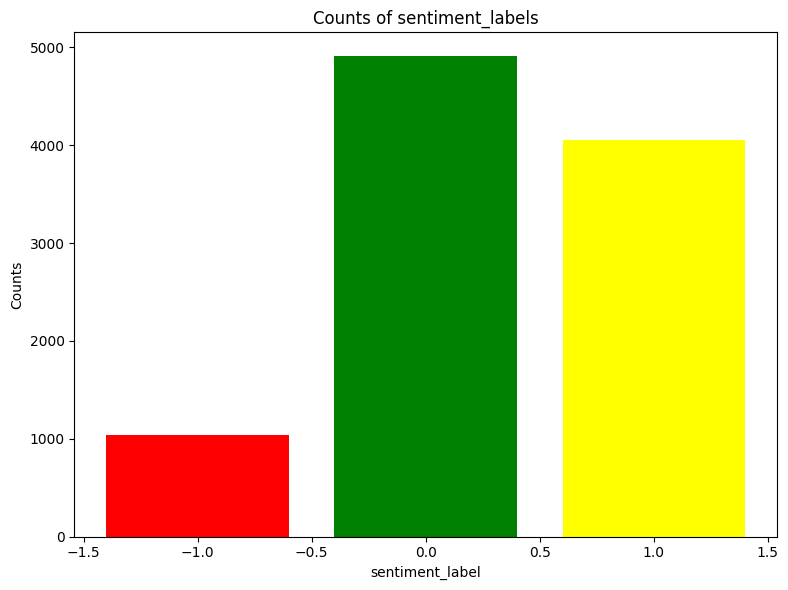

In [ ]:
# Given data
sentiment_label = df['label'].value_counts()

# Create a bar chart
plt.figure(figsize=(8,6))
plt.bar(sentiment_label.index,sentiment_label.values, color=['green', 'yellow', 'red'])
plt.xlabel('sentiment_label')
plt.ylabel('Counts')
plt.title('Counts of sentiment_labels')
plt.tight_layout()

# Display the chart
plt.show()


**label**:  a sentiment or categorization label assigned to each tweet:

**1.0** represent a positive or pro-vaccine sentiment.

**0.0** might represent a neutral sentiment.

**-1.0** might represent a negative or anti-vaccine sentiment.

2. Examining Agreement Levels

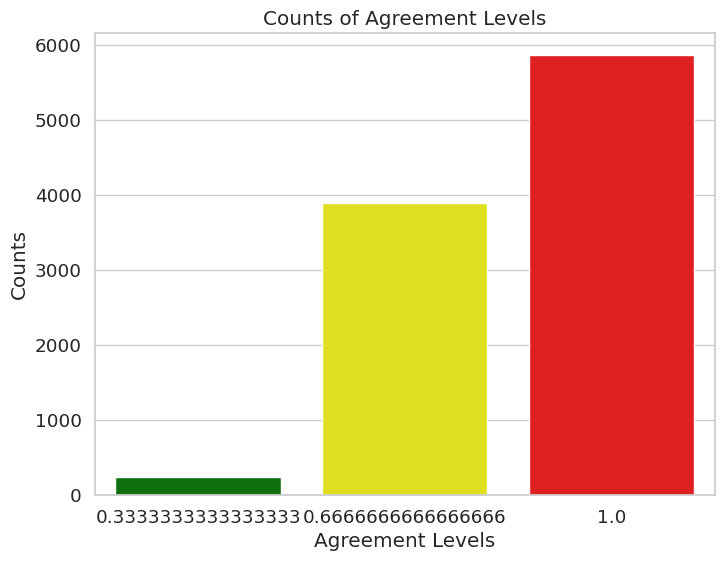

In [ ]:
agreement_levels =df['agreement'].value_counts()

# Setting up the style and context for a nicer plot
sns.set_style("whitegrid")
sns.set_context("notebook", font_scale=1.2)

# Create a bar chart using seaborn
plt.figure(figsize=(8,6))
sns.barplot(x=agreement_levels.index, y=agreement_levels.values, palette=['green', 'yellow', 'red'])
plt.xlabel('Agreement Levels')
plt.ylabel('Counts')
plt.title('Counts of Agreement Levels')

# Display the chart
plt.show()



- **1.000000 (5866 occurrences)**:
  - This suggests full agreement among the annotators. Every annotator felt the sentiment or stance expressed in these texts was the same (e.g., all felt it was positive, negative, or neutral towards vaccination). This could mean that these texts have clear sentiments, like "Vaccines are life-saving!" (clearly positive) or "Vaccines cause harm!" (clearly negative).

- **0.666667 (3,894 occurrences)**:
  - This would mean that there's a majority agreement among the annotators, but not a unanimous one. Assuming three annotators, two agreed on the sentiment or stance, but one felt differently. These texts might be more ambiguous or open to interpretation, such as "I've read both good and bad things about vaccines."

- **0.333333 (239 occurrences)**:
  - This indicates a minority agreement. Again, assuming three annotators, only one felt a particular sentiment while the other two felt differently. This could represent texts that are even more ambiguous, nuanced, or perhaps they contain sarcasm which can be challenging to consistently label.


 Vaccine sentiment texts with high agreement levels provide more confidence in the sentiment label, as multiple humans interpreted the sentiment in the same way. On the other hand, texts with lower agreement levels might require further scrutiny, as they could be more controversial, nuanced, or not clearly leaning in a particular sentiment direction.

3. Analyzing Tweet Lengths

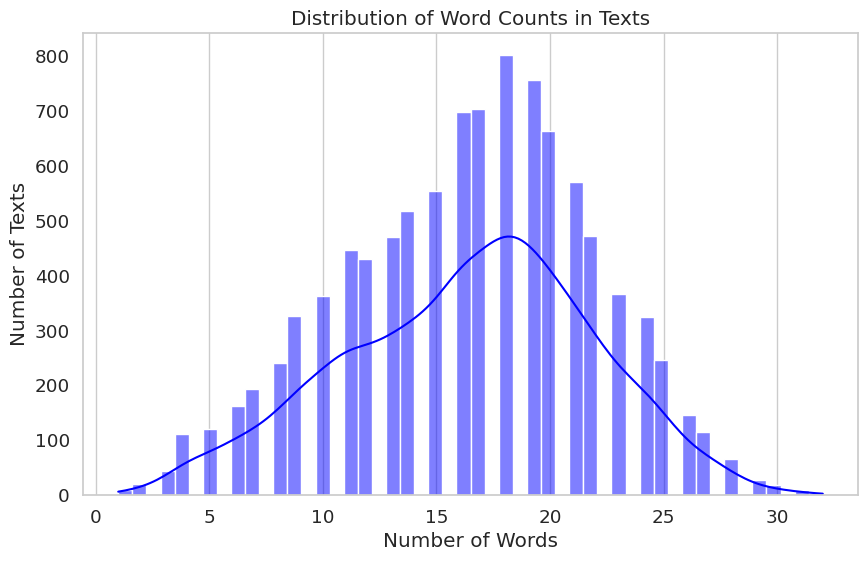

In [ ]:
#computes the number of words in each cleaned tweet
text_len = df['cleaned_safe_text'].apply(lambda x: len(x.split()))

plt.figure(figsize=(10,6))
sns.histplot(text_len, bins=50, color='blue', kde=True)
plt.title('Distribution of Word Counts in Texts')
plt.xlabel('Number of Words')
plt.ylabel('Number of Texts')
plt.grid(axis='y')
plt.show()



4. Overall Word Cloud

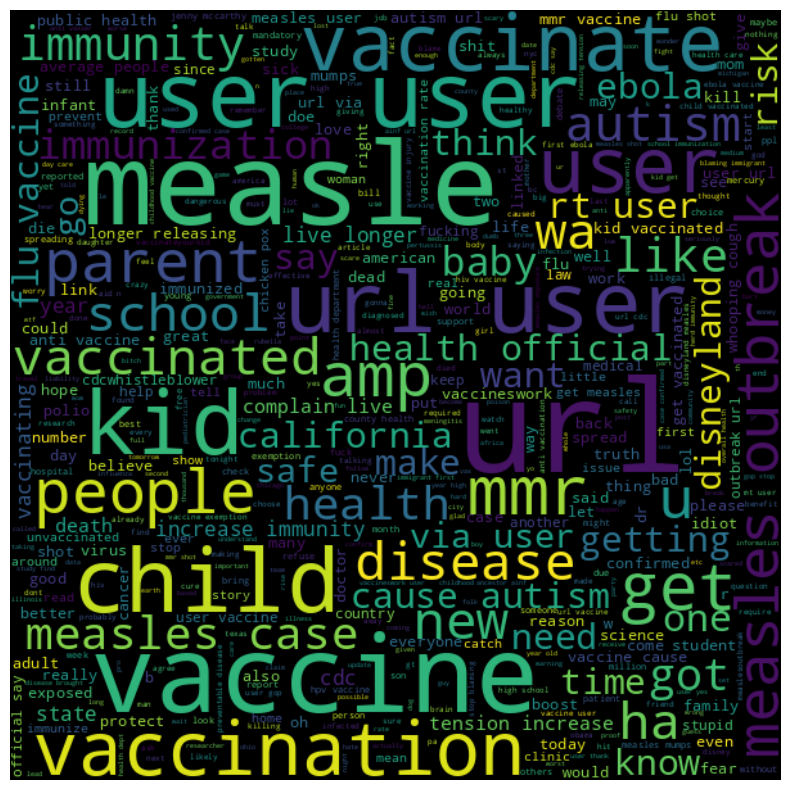

In [ ]:
# Start with one review:
tweets = " ".join(df.cleaned_safe_text)
plt.figure(figsize=(20,10))

stopwords = set(stopwords.words('english'))

# Create and generate a word cloud image:
wordcloud = WordCloud(height=600,width=600,max_font_size=100, max_words=500, stopwords=stopwords).generate(tweets)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

5. Positive Sentiment Word Cloud

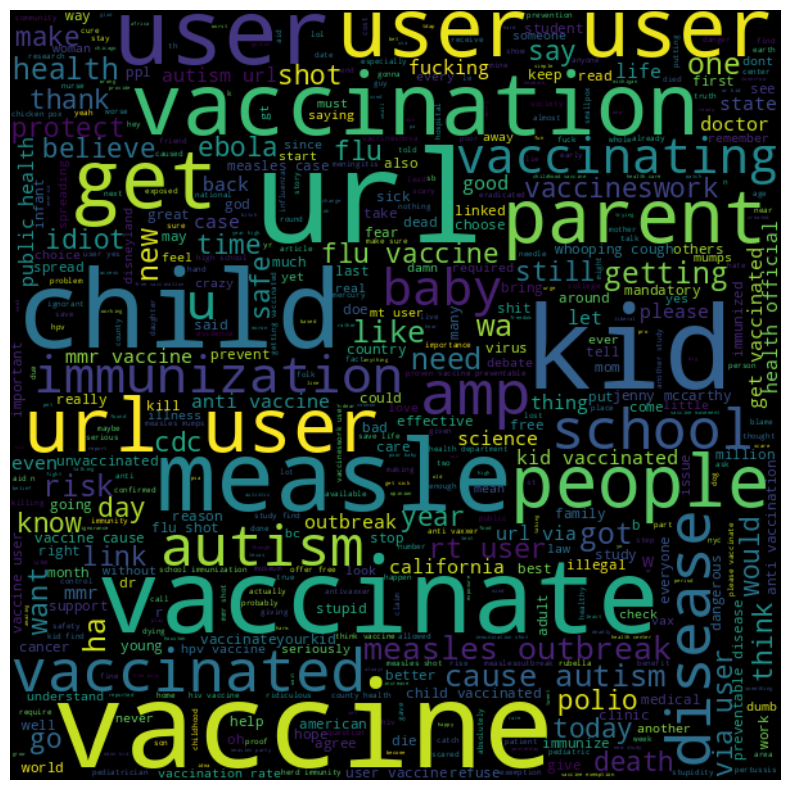

In [ ]:
from nltk.corpus import stopwords
# Filter the dataframe for only positive sentiment (=1) entries
positive_tweets_df = df[df['label'] == 1]

# Combine the cleaned texts of the positive tweets into one long string
tweets = " ".join(positive_tweets_df.cleaned_safe_text)

plt.figure(figsize=(20,10))

# You've already defined 'stopwords' in the code you provided. If not, define it again:
stopwords = set(stopwords.words('english'))

# Create and generate a word cloud image:
wordcloud = WordCloud(height=600, width=600, max_font_size=100, max_words=500, stopwords=stopwords).generate(tweets)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()


6. Neutral Sentiment Word Cloud

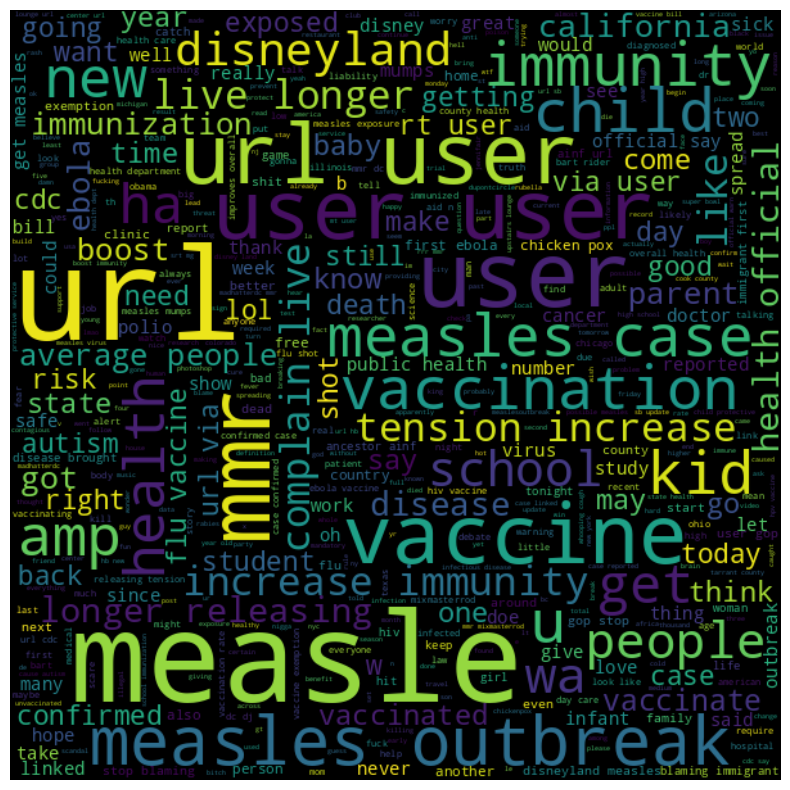

In [ ]:
from nltk.corpus import stopwords
# Filter the dataframe for only neutral sentiment (=0) entries
neutral_tweets_df = df[df['label'] == 0]

# Combine the cleaned texts of the neutral tweets into one long string
tweets = " ".join(neutral_tweets_df.cleaned_safe_text)

plt.figure(figsize=(20,10))
stopwords = set(stopwords.words('english'))

# Create and generate a word cloud image:
wordcloud = WordCloud(height=600, width=600, max_font_size=100, max_words=500, stopwords=stopwords).generate(tweets)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()


7. Negative Sentiment Word Cloud

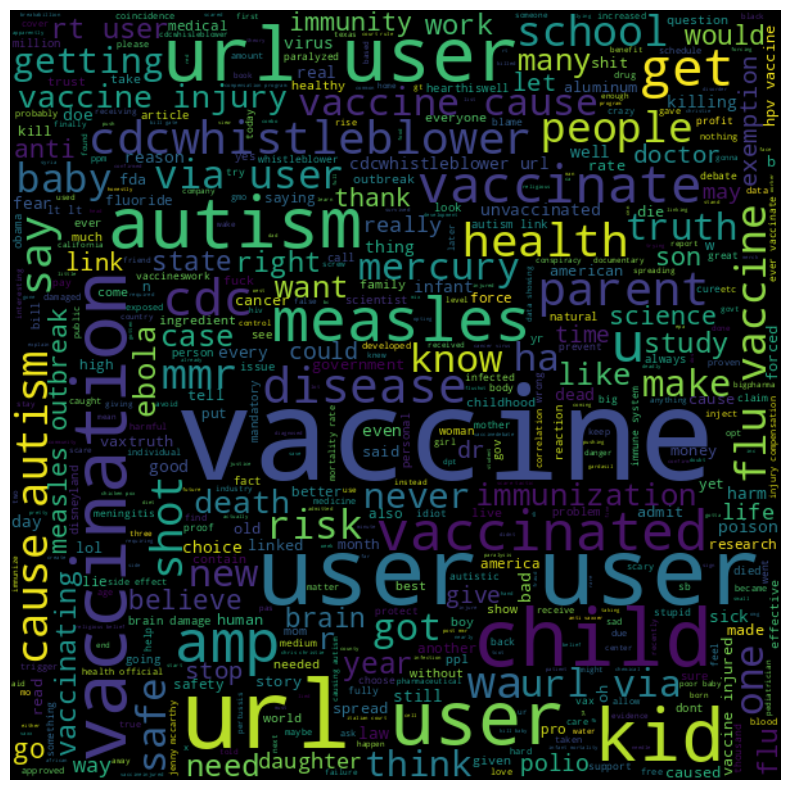

In [ ]:
from nltk.corpus import stopwords
# Filter the dataframe for only negative sentiment (=1) entries
negative_tweets_df = df[df['label'] == -1]

# Combine the cleaned texts of the negative tweets into one long string
tweets = " ".join(negative_tweets_df.cleaned_safe_text)

plt.figure(figsize=(20,10))
stopwords = set(stopwords.words('english'))

# Create and generate a word cloud image:
wordcloud = WordCloud(height=600, width=600, max_font_size=100, max_words=500, stopwords=stopwords).generate(tweets)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()


8. Most Common Hashtags

In [ ]:
# Extract hashtags from the 'safe_text' column
hashtags = df['safe_text'].str.findall(r'#\w+')

# Flatten the list of lists into a single list of hashtags
hashtags = [item for sublist in hashtags for item in sublist]

# Count the frequency of each hashtag
hashtag_freq = Counter(hashtags)

# Get the top 10 hashtags
top_10_hashtags = dict(hashtag_freq.most_common(10))

# Create a bar plot to visualize the top 10 hashtags with the 'viridis' color palette
plt.figure(figsize=(10, 6))
sns.barplot(x=list(top_10_hashtags.keys()), y=list(top_10_hashtags.values()), palette='viridis')
plt.xlabel('Hashtags')
plt.ylabel('Frequency')
plt.title('Top 10 Hashtags')
plt.xticks(rotation=45)
plt.show()

### Splitting the datasets

I manually split the training set to have a training subset ( a dataset the model will learn on), and an evaluation subset ( a dataset the model with use to compute metric scores to help use to avoid some training problems like [the overfitting](https://www.ibm.com/cloud/learn/overfitting) one ).


In [ ]:
# Split the train data => {train, eval}
train, eval = train_test_split(df, test_size=0.2, random_state=42, stratify=df['label'])

In [ ]:
train.head()

In [ ]:
eval.head()

In [ ]:
print(f"new dataframe shapes: train is {train.shape}, eval is {eval.shape}")

In [ ]:
# Save splitted subsets

# Define file path

file_path = '/content/drive/MyDrive/NLP_LP5'

#"/content/drive/MyDrive/NLP_LP5 "

train.to_csv(os.path.join(file_path, "train_subset.csv"), index=False)
eval.to_csv(os.path.join(file_path, "eval_subset.csv"), index=False)

In [ ]:
# Define paths and model name

model_name = 'cardiffnlp/twitter-roberta-base-sentiment-latest'


This is a RoBERTa-base model trained on ~124M tweets from January 2018 to December 2021, and finetuned for sentiment analysis with the TweetEval benchmark.

In [ ]:
# One-hot encode labels
def transform_labels_to_onehot(example):
    label = example['label']
    if label == -1: # 'Negative'
        return {'label': [1, 0, 0]}
    elif label == 0: # 'Neutral'
        return {'label': [0, 1, 0]}
    elif label == 1: # 'Positive'
        return {'label': [0, 0, 1]}


In [ ]:
# Load the dataset
try:
    datasets = load_dataset('csv', data_files={
        'train': '/content/drive/MyDrive/NLP_LP5/train_subset.csv',
        'eval': '/content/drive/MyDrive/NLP_LP5/eval_subset.csv'
    }, encoding='ISO-8859-1')
except Exception as e:
    print(f"An error occurred while loading the datasets: {e}")
    raise

Extracting data files:   0%|          | 0/2 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating eval split: 0 examples [00:00, ? examples/s]

In [ ]:
try:
    # Remove the 'safe_text', 'agreement', and 'tweet_id' columns from the 'datasets' object
    datasets = datasets.remove_columns(['safe_text', 'agreement', 'tweet_id'])
except Exception as e:
    # Handle and report any errors that occur during column removal
    print(f"An error occurred while dropping the columns: {e}")
    raise


In [ ]:

try:
    datasets = datasets.map(transform_labels_to_onehot)
except Exception as e:
    print(f"An error occurred during label transformation: {e}")
    raise


Map:   0%|          | 0/7999 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

###Addressing Class Imbalance through Class Weights

Class imbalance can significantly impact the performance of a classifier, leading to poor generalization for the minority class. To mitigate this, we will calculate class weights that will allow the model to give more importance to less frequent classes during the training process.

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
label = train['label'].tolist()
class_weights = compute_class_weight('balanced', classes=np.unique(label), y=label)
class_weights_dict = {0: class_weights[0], 1: class_weights[1], 2: class_weights[2]}
class_weights_tensor = torch.tensor([class_weights_dict[i] for i in range(len(class_weights_dict))], dtype=torch.float).to(device)


In [ ]:
print(class_weights)  # This should give you an array of weights.
print(class_weights_dict)  # This should give you a dictionary mapping class indices to their weights.


[3.20858404 0.67914756 0.82243471]
{0: 3.208584035298837, 1: 0.6791475632535235, 2: 0.8224347110836931}


In [ ]:
print(class_weights_tensor)
print(class_weights_tensor.device)  # Should match the device you're training on (e.g., 'cuda:0')


tensor([3.2086, 0.6791, 0.8224], device='cuda:0')
cuda:0


In [ ]:
# Load the tokenizer
try:
    tokenizer = AutoTokenizer.from_pretrained(model_name)
except Exception as e:
    print(f"An error occurred while loading the tokenizer for {model_name}: {e}")
    raise  # Raise exception to halt the execution

In [ ]:
# Preprocessing function
def preprocess_function(examples):
    return tokenizer(examples['cleaned_safe_text'], padding='max_length', max_length=128)

# Tokenize the datasets
try:
    encoded_datasets = datasets.map(preprocess_function, batched=True)
except Exception as e:
    print(f"An error occurred during tokenization using {model_name}: {e}")
    raise  # Raise exception to halt the execution


Map:   0%|          | 0/7999 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [ ]:
# Load the model
try:
    model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=3)

except Exception as e:
    print(f"An error occurred while loading the model {model_name}: {e}")
    raise  # Raise exception to halt the execution


Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
# Custom Trainer class with custom loss function using class weights
class CustomTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits = outputs.logits
        loss_fct = CrossEntropyLoss(weight=class_weights_tensor)
        loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))
        return (loss, outputs) if return_outputs else loss

    def create_optimizer_and_scheduler(self, num_training_steps: int):
        # This is necessary to create the scheduler at the right time within the Trainer
        super().create_optimizer_and_scheduler(num_training_steps)
        self.lr_scheduler = ReduceLROnPlateau(
            self.optimizer,
            mode='min',
            factor=0.1,
            patience=1,
            verbose=True
        )


In [ ]:
# Define the training arguments
training_args = TrainingArguments(
    output_dir=f'cardiffnlp_twitter_roberta_base_sentiment_latest_Nov2023',
    num_train_epochs=2,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    warmup_steps=500,
    weight_decay=0.2,
    logging_dir=f'./logs_{model_name}',
    logging_steps=100,
    evaluation_strategy="steps",
    save_strategy="steps",
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    learning_rate=2e-5,
    group_by_length=True,
    push_to_hub=True
)

def compute_metrics(p):
    pred, labels= p

    # Convert predictions to class index format
    pred = np.argmax(pred, axis=1)

    # If true labels are in one-hot encoded format, convert them to class index format
    if len(labels.shape) > 1 and labels.shape[1] > 1:
        labels = np.argmax(labels, axis=1)

    acc = accuracy_score(labels, pred)

    return {"accuracy": acc}

# Initialize the trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=encoded_datasets["train"],
    eval_dataset=encoded_datasets["eval"],
    compute_metrics=compute_metrics,
)
# Train the model
try:
    trainer.train()
except Exception as e:
    print(f"An error occurred while training the model {model_name}: {e}")
    raise  # Raise exception to halt the execution

# Evaluate the model
try:
    results = trainer.evaluate()
    print(f"Results for {model_name}: {results}")
except Exception as e:
    print(f"An error occurred during evaluation of the model {model_name}: {e}")
    raise

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Step,Training Loss,Validation Loss,Accuracy
100,0.661900,0.522570,0.628500
200,0.452600,0.414964,0.716000
300,0.409200,0.389781,0.728000
400,0.388600,0.344120,0.773000
500,0.382200,0.349444,0.767000
600,0.339600,0.347033,0.786500
700,0.315600,0.341764,0.787500
800,0.309900,0.323080,0.794000
900,0.299400,0.337110,0.788500
1000,0.290700,0.318882,0.805000


# Visualizing the results

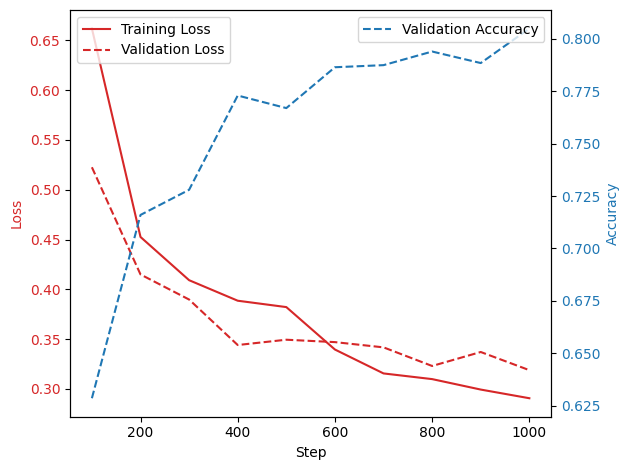

In [ ]:

training_logs = trainer.state.log_history

# Initialize lists to store the metrics for plotting
train_loss_set = []
eval_loss_set = []
train_acc_set = []
eval_acc_set = []
steps_set = []
eval_steps = []

# Loop through the training logs
for log in training_logs:
    if 'loss' in log and 'epoch' in log:  # Training loss
        train_loss_set.append(log['loss'])
        steps_set.append(log['step'])
    if 'eval_loss' in log and 'eval_accuracy' in log:  # Evaluation loss and accuracy
        eval_loss_set.append(log['eval_loss'])
        eval_acc_set.append(log['eval_accuracy'])
        eval_steps.append(log['step'])

# Plotting
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Step')
ax1.set_ylabel('Loss', color=color)
ax1.plot(steps_set, train_loss_set, label='Training Loss', color=color)
ax1.tick_params(axis='y', labelcolor=color)

# We need to ensure that eval points are aligned with training steps if logging frequencies differ
ax1.plot(eval_steps, eval_loss_set, label='Validation Loss', color=color, linestyle='dashed')
ax1.legend(loc='upper left')

ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('Accuracy', color=color)
ax2.plot(eval_steps, eval_acc_set, label='Validation Accuracy', color=color, linestyle='dashed')
ax2.tick_params(axis='y', labelcolor=color)
ax2.legend(loc='upper right')

fig.tight_layout()
plt.show()


Training Loss (Solid Red Line): This line represents the model’s error or loss on the training dataset as it learns. It starts high and should decrease over time, indicating that the model is getting better at predicting the sentiments correctly.

Validation Loss (Dashed Red Line): This line shows the model’s loss on the validation dataset. It’s crucial for this to decrease and then stabilize, which would suggest that the model generalizes well to new, unseen data.

Validation Accuracy (Dashed Blue Line): Representing the accuracy on the validation dataset, this line tells us the proportion of tweets for which the model predicted the sentiment correctly. Ideally, this should increase over time, indicating that the model’s predictions are becoming more accurate.

# Interpreting the Trends

From the graph, we can observe that:

The training loss decreases sharply at first and then begins to plateau, which is a normal behavior indicating that the model is learning and then stabilizing in its predictions on the training data.

The validation loss follows a similar trend to the training loss, decreasing and then leveling out, which suggests that the model is not just memorizing the training data but also generalizing well to the evaluation data.

The validation accuracy initially increases as the model trains, but it shows some fluctuations towards the end. These fluctuations can be due to several reasons, such as the model encountering more challenging examples or the evaluation data having some variability.

# Pushing the model to Hugging Face

In [ ]:
trainer.push_to_hub()


'https://huggingface.co/Feiiisal/cardiffnlp_twitter_roberta_base_sentiment_latest_Nov2023/tree/main/'

In [ ]:
tokenizer.push_to_hub('cardiffnlp_twitter_roberta_base_sentiment_latest_Nov2023')

CommitInfo(commit_url='https://huggingface.co/Feiiisal/cardiffnlp_twitter_roberta_base_sentiment_latest_Nov2023/commit/1a40a8a8937d6eb2d0a33dd065a46fe213988a5c', commit_message='Upload tokenizer', commit_description='', oid='1a40a8a8937d6eb2d0a33dd065a46fe213988a5c', pr_url=None, pr_revision=None, pr_num=None)